In [165]:
# 예측 결과 데이터 불러오기
import pandas as pd

kospi_result = pd.read_csv("kospi_result.csv", index_col = 0)
sp500_result = pd.read_csv("sp500_result.csv", index_col = 0)
euro_result = pd.read_csv("euro_result.csv", index_col = 0)
wti_result = pd.read_csv("wti_result.csv", index_col = 0)
csi300_result = pd.read_csv("csi300_result.csv", index_col = 0)
kosdaq150_result = pd.read_csv("kosdaq150_result.csv", index_col = 0)

In [166]:
# datetime 형태로 변환
kospi_result["date"] = pd.to_datetime(kospi_result["date"])
sp500_result["date"] = pd.to_datetime(sp500_result["date"])
euro_result["date"] = pd.to_datetime(euro_result["date"])
wti_result["date"] = pd.to_datetime(wti_result["date"])
csi300_result["date"] = pd.to_datetime(csi300_result["date"])
kosdaq150_result["date"] = pd.to_datetime(kosdaq150_result["date"])

### 안전자산 데이터

In [167]:
# 국고채 10년 ETF 데이터
import FinanceDataReader as fdr

bond_10y_etf = fdr.DataReader("148070", "2010-01-01")
bond_10y_etf = bond_10y_etf.reset_index()
bond_10y_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
bond_10y_etf.head()

,date,open,high,low,close,volume,change
0,2011-10-20,83795,83904,83771,83860,43093,NaN
1,2011-10-21,83724,83779,83346,83487,4286,-0.004448
2,2011-10-24,83509,83509,83167,83199,4303,-0.003450
3,2011-10-25,83321,83439,83276,83363,1186,0.001971
4,2011-10-26,83305,83498,83221,83484,17543,0.001451


In [168]:
# 골드 ETF 데이터
import FinanceDataReader as fdr

gold_etf = fdr.DataReader("132030", "2010-01-01")
gold_etf = gold_etf.reset_index()
gold_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
gold_etf.head()

,date,open,high,low,close,volume,change
0,2010-10-01,9980,10005,9980,9995,53631,NaN
1,2010-10-04,10055,10065,10040,10065,67972,0.007004
2,2010-10-05,10040,10065,10020,10065,13891,0.000000
3,2010-10-06,10225,10295,10220,10285,12205,0.021858
4,2010-10-07,10270,10340,10260,10335,17231,0.004861


In [169]:
# 달러 ETF 데이터
import FinanceDataReader as fdr

dollar_etf = fdr.DataReader("138230", "2010-01-01")
dollar_etf = dollar_etf.reset_index()
dollar_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
dollar_etf.head()

,date,open,high,low,close,volume,change
0,2011-02-24,11069,11089,11017,11090,12591,NaN
1,2011-02-25,11069,11079,11039,11051,3619,-0.003517
2,2011-02-28,11069,11096,11039,11073,3775,0.001991
3,2011-03-02,11069,11079,11051,11073,4788,0.000000
4,2011-03-03,11060,11060,10994,10997,1838,-0.006864


In [170]:
# VAA Score
def vaa_score(df):
    df["close_1y_lag"] = df["close"].shift(252)
    df["close_6m_lag"] = df["close"].shift(121)
    df["close_3m_lag"] = df["close"].shift(60)
    df["close_1m_lag"] = df["close"].shift(20)
    
    df["momentum_1y"] = (df["close"] - df["close_1y_lag"]) - 1
    df["momentum_6m"] = (df["close"] - df["close_6m_lag"]) - 1
    df["momentum_3m"] = (df["close"] - df["close_3m_lag"]) - 1
    df["momentum_1m"] = (df["close"] - df["close_1m_lag"]) - 1
    
    df["vaa_score"] = (12 * df["momentum_1m"]) + (4 * df["momentum_3m"]) + (2 * df["momentum_6m"]) + (1 * df["momentum_1y"])
    
    return df

In [171]:
# 안전자산 date, change, vaa_score 형태로
def clean(df, standard):
    df_vaa = vaa_score(df)
    df_vaa = df_vaa[df_vaa["date"] >= "2018-01-01"][["date", "change", "vaa_score"]].reset_index(drop = True)
    df_vaa = pd.merge(df_vaa, standard["date"], on = "date", how = "inner")
    
    return df_vaa

bond_10y_result = clean(bond_10y_etf, kospi_result)
gold_result = clean(gold_etf, kospi_result)
dollar_result = clean(dollar_etf, kospi_result)

### EMP 백테스팅

In [221]:
# 각 자산별 투자 비중
weight = pd.DataFrame(columns = ["kodex200", "sp500", "euro_stoxx50", "wti", "csi300", "kosdaq150", "bond_10y", "gold", "dollar"])

for i in range(0, len(kospi_result)):
    
    # 위험자산의 predict가 모두 0일 때, 안전자산 중 VAA Score가 가장 높은 자산에 비중 100% 투자
    if (kospi_result["predict"][i] == 0) and (sp500_result["predict"][i] == 0) and (euro_result["predict"][i] == 0) and (wti_result["predict"][i] == 0) and (csi300_result["predict"][i] == 0) and (kosdaq150_result["predict"][i] == 0):
        riskless = [bond_10y_result["vaa_score"][i], gold_result["vaa_score"][i], dollar_result["vaa_score"][i]]
        loc = riskless.index(max(riskless))
        
        weight_list = [0 for zero in range(0, 9)]
        weight_list[loc + 6] = 1
        weight.loc[i] = weight_list
    
    else:
        # predict = 1인 자산 추출
        pred_list = [kospi_result["predict"][i], sp500_result["predict"][i], euro_result["predict"][i], wti_result["predict"][i], csi300_result["predict"][i], kosdaq150_result["predict"][i]]
        pred_loc = []
        for j in range(0, 6):
            if pred_list[j] == 1:
                pred_loc.append(j)
        
        vaa_list = [kospi_result["vaa_score"][i], sp500_result["vaa_score"][i], euro_result["vaa_score"][i], wti_result["vaa_score"][i], csi300_result["vaa_score"][i], kosdaq150_result["vaa_score"][i]]
        plus_list = []
        for loc in pred_loc:
            if vaa_list[loc] >= 0:
                plus_list.append(loc)
        
        # 위험자산의 predict가 1인 자산들 중 VAA Score가 모두 음수라면, 위험자산에 동일 가중으로 투자
        if sum(plus_list) == 0:
            weight.loc[i] = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 0, 0, 0]
            
        # 위험자산의 predict가 1인 자산들 중 VAA Score가 양수인 위험 자산에 VAA Score 가중치에 따른 비중으로 투자
        else:
            
            # predict = 1인 자산의 VAA Score 합
            vaa_sum = 0
            for k in plus_list:
                vaa_sum = vaa_sum + vaa_list[k]
                
            # predict = 1인 자산의 VAA Score 비중에 따른 투자 비중
            vaa_weight = []
            for k in plus_list:
                ind_weight = vaa_list[k] / vaa_sum
                vaa_weight.append(ind_weight)
                
            weight_list = [0 for zero in range(0, 9)]
            for l in range(0, len(plus_list)):
                weight_list[pred_loc[l]] = vaa_weight[l]
        
            weight.loc[i] = weight_list
            
weight

,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar
0,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0
1,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0
2,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0
3,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0
4,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
736,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0
737,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0
738,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0
739,0.566896,0.248181,0.049477,0.014988,0.000000,0.120458,0.0,0.0,0.0


In [344]:
# EMP 포트폴리오의 매 기 별 수익률 산출

weighted_return = []
for i in range(0, len(weight) - 1):
    # 위험 자산
    weighted_kodex200 = weight["kodex200"][i] * kospi_result["change"][i+1]
    weighted_sp500 = weight["sp500"][i] * sp500_result["change"][i+1]
    weighted_euro_stoxx50 = weight["euro_stoxx50"][i] * euro_result["change"][i+1]
    weighted_wti = weight["wti"][i] * wti_result["change"][i+1]
    weighted_csi300 = weight["csi300"][i] * csi300_result["change"][i+1]
    weighted_kosdaq150 = weight["kosdaq150"][i] * kosdaq150_result["change"][i+1]
    
    # 안전 자산
    weighted_bond_10y = weight["bond_10y"][i] * bond_10y_result["change"][i+1]
    weighted_gold = weight["gold"][i] * gold_result["change"][i+1]
    weighted_dollar = weight["dollar"][i] * dollar_result["change"][i+1]
    
    # 매 기 별 수익률
    ind_return = 1 + (weighted_kodex200 + weighted_sp500 + weighted_euro_stoxx50 + weighted_wti + weighted_csi300 + weighted_kosdaq150 + weighted_bond_10y + weighted_gold + weighted_dollar)
    weighted_return.append(ind_return)

emp_result = weight[:740].copy()
emp_result.insert(0, "date", kospi_result["date"][:740])
emp_result["return"] = weighted_return

emp_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return
0,2018-01-02,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0,1.012097
1,2018-01-03,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0,0.987605
2,2018-01-04,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0,1.021974
3,2018-01-05,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0,1.017165
4,2018-01-08,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0,0.997405
...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.540150,0.273464,0.062897,0.009495,0.000000,0.113994,0.0,0.0,0.0,1.015787
736,2021-02-01,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0,1.013836
737,2021-02-02,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0,1.009739
738,2021-02-03,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0,0.988192


In [345]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(emp_result)):
    new_asset = new_asset * emp_result["return"][i]
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

emp_result["cum_return(%)"] = cum_return
emp_result["asset_value"] = asset_value

emp_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,cum_return(%),asset_value
0,2018-01-02,0.000000,0.389649,0.000000,0.000000,0.067065,0.543286,0.0,0.0,0.0,1.012097,1.209746,1.012097
1,2018-01-03,0.000000,0.387347,0.000000,0.000000,0.072689,0.539964,0.0,0.0,0.0,0.987605,-0.044748,0.999553
2,2018-01-04,0.000000,0.421318,0.000000,0.000000,0.071175,0.507507,0.0,0.0,0.0,1.021974,2.151686,1.021517
3,2018-01-05,0.000000,0.396202,0.000000,0.000000,0.075396,0.528402,0.0,0.0,0.0,1.017165,3.905086,1.039051
4,2018-01-08,0.000000,0.378743,0.000000,0.000000,0.070806,0.550451,0.0,0.0,0.0,0.997405,3.635492,1.036355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.540150,0.273464,0.062897,0.009495,0.000000,0.113994,0.0,0.0,0.0,1.015787,27.552485,1.275525
736,2021-02-01,0.569450,0.242355,0.045195,0.008042,0.000000,0.134957,0.0,0.0,0.0,1.013836,29.317343,1.293173
737,2021-02-02,0.573244,0.248307,0.048207,0.009826,0.000000,0.120416,0.0,0.0,0.0,1.009739,30.576803,1.305768
738,2021-02-03,0.571468,0.249395,0.050768,0.010981,0.000000,0.117388,0.0,0.0,0.0,0.988192,29.034987,1.290350


In [346]:
# EMP 포트폴리오 성과 지표
import numpy as np

def portfolio_report(df):
    pf_report = pd.DataFrame()
    
    # MDD
    arr_v = np.array(df["asset_value"])
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    mdd = (arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]
    
    # CAGR
    diff = df["date"].iloc[-1] - df["date"].iloc[0]
    N = diff.days / 365
    cum = (1 + (df["cum_return(%)"][739] * 0.01))
    CAGR = (cum**(1/N)) - 1
    
    # Sharp ratio ((CAGR - rf) / vol_year) : 표준편차 => 약 3년 간의 daily return * sqrt(252)
    std = np.std(df["return"]) * np.sqrt(252)
    rf = 0.03
    SR = (CAGR - rf) / std
    
    pf_report["cum_return"] = [round(df["cum_return(%)"][739], 2)]
    pf_report["CAGR"] = round(CAGR * 100, 3)
    pf_report["MDD"] = round(mdd * 100, 3)
    pf_report["SR"] = round(SR, 3)
    pf_report["Std"] = round(std, 3)

    return pf_report

In [348]:
portfolio_report(emp_result).T

,0
cum_return,30.590
CAGR,9.012
MDD,-31.784
SR,0.302
Std,0.199


### 동일 가중 포트폴리오

In [341]:
# 동일 가중 포트폴리오의 매 기 별 수익률 산출
equal_weight = pd.DataFrame(columns = ["kodex200", "sp500", "euro_stoxx50", "wti", "csi300", "kosdaq150", "bond_10y", "gold", "dollar"])
for i in range(0, 741):
    equal_weight.loc[i] = [1/9 for w in range(0, 9)]
#     [1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 0, 0, 0]
#     

equal_weighted_return = []
for i in range(0, len(equal_weight) - 1):
    # 위험 자산
    equal_weighted_kodex200 = equal_weight["kodex200"][i] * kospi_result["change"][i+1]
    equal_weighted_sp500 = equal_weight["sp500"][i] * sp500_result["change"][i+1]
    equal_weighted_euro_stoxx50 = equal_weight["euro_stoxx50"][i] * euro_result["change"][i+1]
    equal_weighted_wti = equal_weight["wti"][i] * wti_result["change"][i+1]
    equal_weighted_csi300 = equal_weight["csi300"][i] * csi300_result["change"][i+1]
    equal_weighted_kosdaq150 = equal_weight["kosdaq150"][i] * kosdaq150_result["change"][i+1]
    
    # 안전 자산
    equal_weighted_bond_10y = equal_weight["bond_10y"][i] * bond_10y_result["change"][i+1]
    equal_weighted_gold = equal_weight["gold"][i] * gold_result["change"][i+1]
    equal_weighted_dollar = equal_weight["dollar"][i] * dollar_result["change"][i+1]
    
    # 매 기 별 수익률
    ind_return = 1 + (equal_weighted_kodex200 + equal_weighted_sp500 + equal_weighted_euro_stoxx50 + equal_weighted_wti + equal_weighted_csi300 + equal_weighted_kosdaq150 + equal_weighted_bond_10y + equal_weighted_gold + equal_weighted_dollar)
    equal_weighted_return.append(ind_return)

equal_result = equal_weight[:740].copy()
equal_result.insert(0, "date", kospi_result["date"][:740])
equal_result["return"] = equal_weighted_return

equal_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return
0,2018-01-02,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.003775
1,2018-01-03,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.000322
2,2018-01-04,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.009066
3,2018-01-05,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.004885
4,2018-01-08,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.000325
...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.009940
736,2021-02-01,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.009869
737,2021-02-02,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.005459
738,2021-02-03,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.997038


In [342]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(equal_result)):
    new_asset = new_asset * equal_result["return"][i]
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

equal_result["cum_return(%)"] = cum_return
equal_result["asset_value"] = asset_value

equal_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,cum_return(%),asset_value
0,2018-01-02,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.003775,0.377457,1.003775
1,2018-01-03,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.000322,0.409800,1.004098
2,2018-01-04,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.009066,1.320080,1.013201
3,2018-01-05,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.004885,1.815015,1.018150
4,2018-01-08,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.000325,1.848140,1.018481
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.009940,10.729247,1.107292
736,2021-02-01,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.009869,11.822088,1.118221
737,2021-02-02,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,1.005459,12.432557,1.124326
738,2021-02-03,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.997038,12.099530,1.120995


In [343]:
portfolio_report(equal_result).T

,0
cum_return,12.760
CAGR,3.958
MDD,-26.467
SR,0.075
Std,0.128


### 전통적인 VAA 전략 구현

In [231]:
# 각 자산별 투자 비중
trad_vaa = pd.DataFrame(columns = ["kodex200", "sp500", "euro_stoxx50", "wti", "csi300", "kosdaq150", "bond_10y", "gold", "dollar"])

for i in range(0, len(kospi_result)):
    if (kospi_result["vaa_score"][i] > 0) and (sp500_result["vaa_score"][i] > 0) and (euro_result["vaa_score"][i] > 0) and (wti_result["vaa_score"][i] > 0) and (csi300_result["vaa_score"][i] > 0) and (kosdaq150_result["vaa_score"][i] > 0):
        trad_vaa_list = [kospi_result["vaa_score"][i], sp500_result["vaa_score"][i], euro_result["vaa_score"][i], wti_result["vaa_score"][i], csi300_result["vaa_score"][i], kosdaq150_result["vaa_score"][i]]
        loc = trad_vaa_list.index(max(trad_vaa_list))
        
        trad_weight_list = [0 for zero in range(0, 9)]
        trad_weight_list[loc] = 1
        trad_vaa.loc[i] = trad_weight_list
        
    else:
        riskless = [bond_10y_result["vaa_score"][i], gold_result["vaa_score"][i], dollar_result["vaa_score"][i]]
        loc = riskless.index(max(riskless))
        
        trad_weight_list = [0 for zero in range(0, 9)]
        trad_weight_list[loc + 6] = 1
        trad_vaa.loc[i] = trad_weight_list
        
trad_vaa

,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
736,1,0,0,0,0,0,0,0,0
737,1,0,0,0,0,0,0,0,0
738,1,0,0,0,0,0,0,0,0
739,1,0,0,0,0,0,0,0,0


In [233]:
trad_vaa_return = []
for i in range(0, len(trad_vaa) - 1):
    # 위험 자산
    trad_vaa_kodex200 = trad_vaa["kodex200"][i] * kospi_result["change"][i+1]
    trad_vaa_sp500 = trad_vaa["sp500"][i] * sp500_result["change"][i+1]
    trad_vaa_euro_stoxx50 = trad_vaa["euro_stoxx50"][i] * euro_result["change"][i+1]
    trad_vaa_wti = trad_vaa["wti"][i] * wti_result["change"][i+1]
    trad_vaa_csi300 = trad_vaa["csi300"][i] * csi300_result["change"][i+1]
    trad_vaa_kosdaq150 = trad_vaa["kosdaq150"][i] * kosdaq150_result["change"][i+1]
    
    # 안전 자산
    trad_vaa_bond_10y = trad_vaa["bond_10y"][i] * bond_10y_result["change"][i+1]
    trad_vaa_gold = trad_vaa["gold"][i] * gold_result["change"][i+1]
    trad_vaa_dollar = trad_vaa["dollar"][i] * dollar_result["change"][i+1]
    
    # 매 기 별 수익률
    ind_return = 1 + (trad_vaa_kodex200 + trad_vaa_sp500 + trad_vaa_euro_stoxx50 + trad_vaa_wti + trad_vaa_csi300 + trad_vaa_kosdaq150 + trad_vaa_bond_10y + trad_vaa_gold + trad_vaa_dollar)
    trad_vaa_return.append(ind_return)

trad_vaa_result = trad_vaa[:740].copy()
trad_vaa_result.insert(0, "date", kospi_result["date"][:740])
trad_vaa_result["return"] = trad_vaa_return

trad_vaa_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return
0,2018-01-02,0,0,0,0,0,1,0,0,0,1.016072
1,2018-01-03,0,0,0,0,0,1,0,0,0,0.972336
2,2018-01-04,0,0,0,0,0,1,0,0,0,1.038484
3,2018-01-05,0,0,0,0,0,1,0,0,0,1.027534
4,2018-01-08,0,0,0,0,0,1,0,0,0,0.994762
...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,1,0,0,0,0,0,0,0,0,1.024924
736,2021-02-01,1,0,0,0,0,0,0,0,0,1.014828
737,2021-02-02,1,0,0,0,0,0,0,0,0,1.008299
738,2021-02-03,1,0,0,0,0,0,0,0,0,0.983306


In [234]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(trad_vaa_result)):
    new_asset = new_asset * trad_vaa_result["return"][i]
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

trad_vaa_result["cum_return(%)"] = cum_return
trad_vaa_result["asset_value"] = asset_value

trad_vaa_result

,date,kodex200,sp500,euro_stoxx50,wti,csi300,kosdaq150,bond_10y,gold,dollar,return,cum_return(%),asset_value
0,2018-01-02,0,0,0,0,0,1,0,0,0,1.016072,1.607193,1.016072
1,2018-01-03,0,0,0,0,0,1,0,0,0,0.972336,-1.203625,0.987964
2,2018-01-04,0,0,0,0,0,1,0,0,0,1.038484,2.598414,1.025984
3,2018-01-05,0,0,0,0,0,1,0,0,0,1.027534,5.423393,1.054234
4,2018-01-08,0,0,0,0,0,1,0,0,0,0.994762,4.871141,1.048711
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021-01-29,1,0,0,0,0,0,0,0,0,1.024924,-25.598419,0.744016
736,2021-02-01,1,0,0,0,0,0,0,0,0,1.014828,-24.495193,0.755048
737,2021-02-02,1,0,0,0,0,0,0,0,0,1.008299,-23.868560,0.761314
738,2021-02-03,1,0,0,0,0,0,0,0,0,0.983306,-25.139477,0.748605


In [332]:
portfolio_report(trad_vaa_result).T

,0
cum_return,-24.190
CAGR,-8.563
MDD,-38.364
SR,-0.928
Std,0.125


### 결과 비교

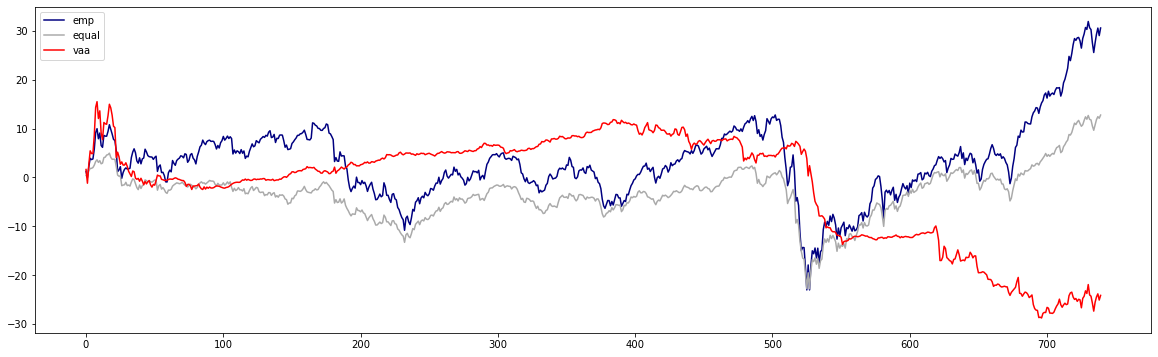

In [302]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 6))

x_1 = emp_result["cum_return(%)"]
x_2 = equal_result["cum_return(%)"]
x_3 = trad_vaa_result["cum_return(%)"]

plt.plot(x_1, color = 'navy', label = 'emp')
plt.plot(x_2, color = '#AAAAAA', label = 'equal')
plt.plot(x_3, color = 'red', label = 'vaa')

# plt.xticks(np.arange(0, 21, 4), labels = label)
# plt.text(18.2, 25, "25.12%")
# plt.text(18.2, 20.14, "20.14%")
plt.legend()
# plt.title("MLP vs All")
plt.show()

### 기타 자산 비교

In [319]:
# kodex200 ETF 데이터
import FinanceDataReader as fdr

kodex200_test = fdr.DataReader("143850", "2018-01-01")
kodex200_test = kodex200_test.reset_index()
kodex200_test.columns = ["date", "open", "high", "low", "close", "volume", "return"]
kodex200_test = pd.merge(kodex200_test, kospi_result["date"], on = "date", how = "inner")
kodex200_test.head()

,date,open,high,low,close,volume,return
0,2018-01-02,31835,31865,31750,31770,25463,-0.003294
1,2018-01-03,31935,31995,31935,31995,11717,0.007082
2,2018-01-04,32135,32210,32135,32205,4384,0.006564
3,2018-01-05,32315,32355,32310,32350,4557,0.004502
4,2018-01-08,32550,32570,32540,32560,18910,0.006491


In [330]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []
for i in range(0, len(kodex200_test)):
    new_asset = new_asset * (1 + kodex200_test["return"][i])
    cum_r = (new_asset - 1) * 100

    cum_return.append(cum_r)
    asset_value.append(new_asset)

kodex200_test["cum_return(%)"] = cum_return
kodex200_test["asset_value"] = asset_value

kodex200_test

,date,open,high,low,close,volume,return,cum_return(%),asset_value
0,2018-01-02,31835,31865,31750,31770,25463,-0.003294,-0.329412,0.996706
1,2018-01-03,31935,31995,31935,31995,11717,0.007082,0.376471,1.003765
2,2018-01-04,32135,32210,32135,32205,4384,0.006564,1.035294,1.010353
3,2018-01-05,32315,32355,32310,32350,4557,0.004502,1.490196,1.014902
4,2018-01-08,32550,32570,32540,32560,18910,0.006491,2.149020,1.021490
...,...,...,...,...,...,...,...,...,...
736,2021-02-01,42880,43415,42860,43350,41797,-0.004478,24.424605,1.244246
737,2021-02-02,43915,44200,43835,44130,80911,0.017993,26.663387,1.266634
738,2021-02-03,44655,44745,44590,44725,56359,0.013483,28.371175,1.283712
739,2021-02-04,44690,44690,44430,44540,15469,-0.004136,27.840182,1.278402


In [331]:
portfolio_report(kodex200_test).T

,0
cum_return,27.840
CAGR,8.257
MDD,-34.991
SR,0.253
Std,0.207


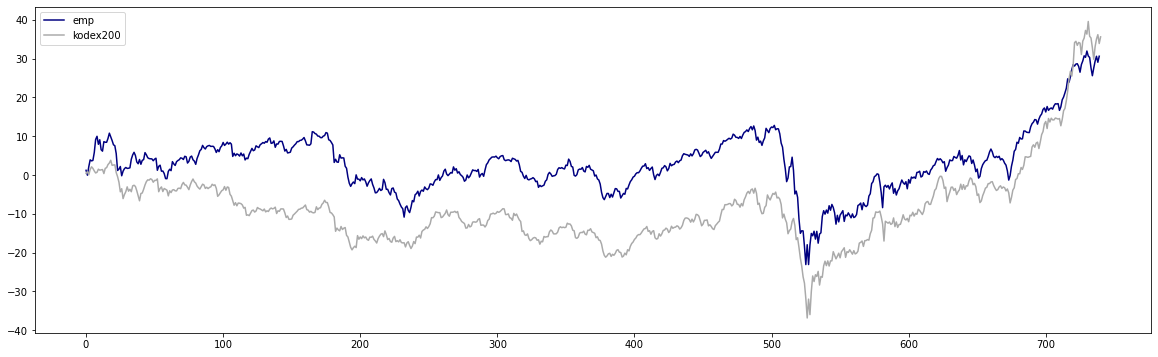

In [315]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 6))

x_1 = emp_result["cum_return(%)"]
x_2 = kodex200_test["cum_return(%)"]

plt.plot(x_1, color = 'navy', label = 'emp')
plt.plot(x_2, color = '#AAAAAA', label = 'kodex200')
# plt.plot(x_3, color = 'red', label = 'vaa')

# plt.xticks(np.arange(0, 21, 4), labels = label)
# plt.text(18.2, 25, "25.12%")
# plt.text(18.2, 20.14, "20.14%")
plt.legend()
# plt.title("MLP vs All")
plt.show()